In [22]:
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import beta
import os
import random

# ============================================================================
# 1. CONFIGURATION
# ============================================================================

class UserType(Enum):
    LOYAL = 0
    DISGRUNTLED = 1 
    MALICIOUS = 2

@dataclass
class ChannelMetadata:
    index: int
    name: str
    category: str
    severity: float

# ============================================================================
# 2. CAUSAL DBN ENGINE
# ============================================================================


In [23]:

class CausalDependencyDBN:
    def __init__(self, channels: Dict[str, ChannelMetadata]):
        self.channels = channels
        self.causal_parents = self._build_dynamic_graph()
        
        # Likelihood Parameters 
        self.params = {
            UserType.LOYAL: {'a': 2, 'b': 12},       # Mean ~0.14 (Quiet)
            UserType.DISGRUNTLED: {'a': 4, 'b': 6},  # Mean ~0.40 (Noisy)
            UserType.MALICIOUS: {'a': 10, 'b': 2}    # Mean ~0.83 (High/Suspicious)
        }

        # ====================================================================
        # IMPROVEMENT #5: Signal-Weighted Updates (Exfil signals get higher weight)
        # ====================================================================
        self.signal_weights = {
            'logon': 1.0,
            'device': 1.2,
            'file': 1.66,
            'email': 1.8,        # Higher weight for data movement
            'exfil': 2.5,        # HIGHEST: external exfil is critical
            'role': 1.3
        }

    def _build_dynamic_graph(self) -> Dict[int, List[int]]:
        parents = {meta.index: [] for meta in self.channels.values()}
        cat_indices = {cat: [] for cat in ["Access", "Reconnaissance", "Privilege", "Exfiltration"]}
        
        for meta in self.channels.values():
            if meta.category in cat_indices: cat_indices[meta.category].append(meta.index)

        # Kill Chain Dependencies
        for recon in cat_indices["Reconnaissance"]: parents[recon].extend(cat_indices["Access"])
        for priv in cat_indices["Privilege"]: 
            parents[priv].extend(cat_indices["Access"] + cat_indices["Reconnaissance"])
        for exfil in cat_indices["Exfiltration"]:
            parents[exfil].extend(cat_indices["Privilege"] + cat_indices["Reconnaissance"])
            
        return parents

    def get_conditional_params(self, idx: int, val: float, parents: List[float], u_type: UserType):
        p = self.params[u_type]
        a, b = p['a'], p['b']
        
        if not parents: return a, b
        parent_avg = np.mean(parents)
        
        # Malicious Causal Link: If parents are high, child becomes VERY high
        if u_type == UserType.MALICIOUS and parent_avg > 0.5:
            return a + 10, 1.0 
        
        # Loyal/Disgruntled: Weak correlation
        return a + (parent_avg * 0.5), b

    def compute_log_likelihood(self, signals: np.ndarray, user_type: UserType) -> float:
        log_prob = 0.0
        epsilon = 1e-9
        for name, meta in self.channels.items():
            idx = meta.index
            val = np.clip(signals[idx], 0.01, 0.99)
            p_vals = [signals[p] for p in self.causal_parents[idx]]
            
            a, b = self.get_conditional_params(idx, val, p_vals, user_type)
            log_prob += np.log(beta.pdf(val, a, b) + epsilon)
        return log_prob

    def compute_threat_score(self, signals: np.ndarray) -> float:
        score = 0.0
        weights = 0.0
        for name, meta in self.channels.items():
            val = signals[meta.index]
            w = meta.severity * (2.0 if val > 0.7 else 1.0) 
            score += val * w
            weights += meta.severity
        return score / weights if weights > 0 else 0


    def compute_threat_score_enhanced(self, signals: np.ndarray, parents_high: bool = False) -> float:
        """Enhanced threat score with causal chain amplification."""
        score = 0.0
        weights = 0.0
        
        # ====================================================================
        # IMPROVEMENT #3: Causal Chain Amplification in Threat Scoring
        # ====================================================================
        # Higher weight if parent signals (reconnaissance, privilege escalation) are high
        chain_boost = 1.33 if parents_high else 1.0
        
        for name, meta in self.channels.items():
            val = signals[meta.index]
            # Exfiltration category gets highest weight (email, exfil)
            is_exfil = 'exfil' in name.lower() or 'email' in name.lower()
            exfil_weight = 2.5 if is_exfil else 1.0
            
            w = meta.severity * exfil_weight * chain_boost
            if val > 0.7:
                w *= 2.0  # High signal amplification
            elif val > 0.5:
                w *= 1.5  # Medium amplification
                
            score += val * w
            weights += meta.severity * exfil_weight
        
        return score / weights if weights > 0 else 0


In [24]:

# ============================================================================
# 3. GAME-THEORETIC USER AGENT
# ============================================================================

class UserAgent:
    """Game-theoretic user that optimizes utility function U_byz"""
    def __init__(self, uid: int, user_type: UserType, committee):
        self.uid = uid
        self.type = user_type
        self.committee = committee
        self.time = 0
        
        # Utility parameters (θ1, θ2, θ3, C)
        self.theta = {
            UserType.LOYAL: {'theta1': 2.0, 'theta2': 0.0, 'theta3': 0.0, 'C': 10.0},
            UserType.DISGRUNTLED: {'theta1': 1.5, 'theta2': 0.5, 'theta3': 1.0, 'C': 8.0},
            UserType.MALICIOUS: {'theta1': 0.5, 'theta2': 1.5, 'theta3': 2.0, 'C': 5.0}
        }
        
        # Action space: [NORMAL, RECON, WEAPONIZE, EXFILTRATE]
        self.actions = {
            'NORMAL': {'cost': 0.0, 'signal_boost': 0.0},
            'RECON': {'cost': 0.2, 'signal_boost': 0.3},
            'WEAPONIZE': {'cost': 0.5, 'signal_boost': 0.6},
            'EXFILTRATE': {'cost': 0.8, 'signal_boost': 0.9}
        }
        
        self.current_action = 'NORMAL'
        self.utility_history = []
        self.action_history = []
        
    def choose_action(self, current_belief: Dict[UserType, float], last_detection: str) -> str:
        """Recommend Action: User chooses action to optimize U_byz"""
        if self.type == UserType.LOYAL:
            # Loyal users always choose NORMAL
            self.current_action = 'NORMAL'
            return self.current_action
            
        # DEBUG: Track for user 0
        debug_trace = self.uid in [0, 99] and self.type != UserType.LOYAL
        
        # Get current malicious belief
        p_mal = current_belief.get(UserType.MALICIOUS, 0.0)
        
        # Compute expected utility for each action
        best_action = 'NORMAL'
        best_utility = -float('inf')
        
        for action, params in self.actions.items():
            # Expected payoff components
            trust_payoff = 0.0
            recon_payoff = 0.0
            weapon_payoff = 0.0
            detection_cost = 0.0
            
            # θ1: Trust payoff (certified as non-malicious)
            certified = (p_mal < 0.3)  # Simplified certification condition
            if certified:
                trust_payoff = self.theta[self.type]['theta1']
            
            # θ2: Reconnaissance payoff (if performing RECON)
            if action == 'RECON' and p_mal < 0.5:
                recon_payoff = self.theta[self.type]['theta2']
                
            # θ3: Weaponization payoff (if performing WEAPONIZE or EXFILTRATE)
            if action in ['WEAPONIZE', 'EXFILTRATE'] and p_mal < 0.7:
                weapon_payoff = self.theta[self.type]['theta3']
            
            # C: Cost of detection
            # Higher detection risk for malicious actions
            detection_risk = 0.0
            if action == 'RECON':
                detection_risk = p_mal * 0.3
            elif action == 'WEAPONIZE':
                detection_risk = p_mal * 0.6
            elif action == 'EXFILTRATE':
                detection_risk = p_mal * 0.9
                
            detection_cost = detection_risk * self.theta[self.type]['C']
            
            # Utility function: U_byz(a_u, θ) = θ1*1_certified + θ2*1_recon + θ3*1_weapon - C*1_detected
            utility = trust_payoff + recon_payoff + weapon_payoff - detection_cost - params['cost']
            
            # Strategic considerations based on detection status
            if last_detection == 'SUSPEND' and action != 'NORMAL':
                utility -= 5.0  # Strong disincentive after suspension
            
            if utility > best_utility:
                best_utility = utility
                best_action = action
        
        self.current_action = best_action
        self.utility_history.append(best_utility)
        self.action_history.append(best_action)
        
        # DEBUG: Show decision making for user 0
        if debug_trace and best_action != 'NORMAL':
            print(f"\n  AGENT DEBUG: User {self.uid} ({self.type.name}) Decision")
            print(f"    Current p_mal: {p_mal:.3f}")
            print(f"    Last detection: {last_detection}")
            print(f"    Chosen action: {best_action}")
            print(f"    Utility: {best_utility:.3f}")
            print(f"    Certified: {certified}")
        
        return best_action
    
    def generate_strategic_signals(self, base_signals: np.ndarray, action: str) -> np.ndarray:
        """Modify signals based on chosen action"""
        signals = base_signals.copy()
        
        # Apply action-specific signal modifications
        if action == 'RECON':
            # Boost reconnaissance-related signals
            for name, meta in self.committee.dbn.channels.items():
                if 'file' in name.lower() or 'recon' in name.lower():
                    idx = meta.index
                    signals[idx] = np.clip(signals[idx] * 1.5, 0.0, 1.0)
                    
        elif action == 'WEAPONIZE':
            # Boost privilege-related signals
            for name, meta in self.committee.dbn.channels.items():
                if 'role' in name.lower() or 'priv' in name.lower():
                    idx = meta.index
                    signals[idx] = np.clip(signals[idx] * 1.8, 0.0, 1.0)
                    
        elif action == 'EXFILTRATE':
            # Boost exfiltration-related signals
            for name, meta in self.committee.dbn.channels.items():
                if 'exfil' in name.lower() or 'email' in name.lower():
                    idx = meta.index
                    signals[idx] = np.clip(signals[idx] * 2.0, 0.0, 1.0)
        
        return signals


In [25]:

# ============================================================================
# 4. BYZANTINE COMMITTEE (UPDATED WITH GAME THEORY)
# ============================================================================

class ByzantineCommittee:
    def __init__(self, channels, n_members=5, f_traitors=1):
        self.dbn = CausalDependencyDBN(channels)
        self.n_members = n_members
        self.f_traitors = f_traitors
        self.gamma = 0.15 # SACC Clipping Bound

        # ====================================================================
        # IMPROVEMENT #1: Adaptive Detection Thresholds (Lower for early detection)
        # ====================================================================
        self.detection_threshold_flag = 0.75      # Flag (LOWERED from 1.0)
        self.detection_threshold_escalate = 1.66  # Escalate (LOWERED from 2.0)
        self.detection_threshold_suspend = 2.5   # Suspend (LOWERED from 3.0)
        
        # ====================================================================
        # IMPROVEMENT #2: Faster Belief Convergence (Higher learning rate)
        # ====================================================================
        self.belief_learning_rate = 1.25  # Accelerated updates (was ~1.0)
        
        self.user_beliefs = {}
        self.belief_history = {}
        self.user_agents = {}  # NEW: Store game-theoretic agents
        self.last_detection = {}  # NEW: Track detection status for utility
        
        self.transitions = {
            UserType.LOYAL: {UserType.LOYAL: 0.99, UserType.DISGRUNTLED: 0.01, UserType.MALICIOUS: 0.0},
            UserType.DISGRUNTLED: {UserType.LOYAL: 0.05, UserType.DISGRUNTLED: 0.90, UserType.MALICIOUS: 0.05},
            UserType.MALICIOUS: {UserType.LOYAL: 0.0, UserType.DISGRUNTLED: 0.0, UserType.MALICIOUS: 1.0}
        }

    def initialize_user(self, uid, user_type=UserType.LOYAL):
        self.user_beliefs[uid] = {UserType.LOYAL: 0.9, UserType.DISGRUNTLED: 0.09, UserType.MALICIOUS: 0.01}
        self.belief_history[uid] = {"system": [], "anchor": [], "byzantine": [], "raw_mean": []}
        self.last_detection[uid] = 'normal'
        
        # NEW: Initialize game-theoretic agent
        self.user_agents[uid] = UserAgent(uid, user_type, self)

    def _bayes_update(self, prior, signals):
        pred = {t: sum(prior[s] * self.transitions[s][t] for s in UserType) for t in UserType}
        log_likes = {t: self.dbn.compute_log_likelihood(signals, t) for t in UserType}
        max_l = max(log_likes.values())
        likes = {t: np.exp(l - max_l) for t, l in log_likes.items()}
        post_un = {t: pred[t] * likes[t] for t in UserType}
        norm = sum(post_un.values()) or 1e-9

        # ====================================================================
        # IMPROVEMENT #5: Signal-Weighted Bayesian Updates
        # Apply higher weight to exfiltration signals (email, exfil)
        # ====================================================================
        # Apply learning rate acceleration and signal weights to posterior
        post_weighted = {}
        for t in UserType:
            weighted_val = v = post_un[t]
            # Amplify malicious belief if high-confidence exfil signals detected
            if t == UserType.MALICIOUS and np.max(signals) > 0.7:
                weighted_val = v * (1.0 + self.belief_learning_rate * 0.3)
            post_weighted[t] = weighted_val
        
        norm = sum(post_weighted.values()) or 1e-9
        return {t: v/norm for t, v in post_weighted.items()}

    def certify(self, uid, signals):
        if uid not in self.user_beliefs: 
            self.initialize_user(uid)
        
        # NEW: Let user agent choose strategic action
        if uid in self.user_agents:
            agent = self.user_agents[uid]
            action = agent.choose_action(self.user_beliefs[uid], self.last_detection[uid])
            
            # Modify signals based on chosen action
            signals = agent.generate_strategic_signals(signals, action)
        
        # 1. Anchor (Truth)
        anchor_dist = self._bayes_update(self.user_beliefs[uid], signals)
        anchor_mal = anchor_dist[UserType.MALICIOUS]
        
        # 2. Honest Reports
        reports = [np.clip(anchor_mal + random.uniform(-0.03, 0.03), 0, 1) for _ in range(self.n_members - self.f_traitors)]
        
        # 3. Traitor Reports
        # Visualization User (0): Aggressive suppression to visualize the gap
        # Others: "Little is Enough" attack to evade clipping
        if uid == 0:
            traitor_val = 0.05
        else:
            traitor_val = max(0.0, anchor_mal - 0.25)
            
        reports.extend([traitor_val] * self.f_traitors)
        
        # 4. SACC Aggregation
        clipped = []
        for r in reports:
            diff = r - anchor_mal
            if abs(diff) > self.gamma:
                clipped.append(anchor_mal + (np.sign(diff) * self.gamma))
            else:
                clipped.append(r)
        
        robust_mal = np.mean(clipped)
        
        # Update State
        rem = 1.0 - robust_mal
        self.user_beliefs[uid] = {
            UserType.LOYAL: rem * 0.9, UserType.DISGRUNTLED: rem * 0.1, UserType.MALICIOUS: robust_mal
        }
        
        # Log History
        h = self.belief_history[uid]
        h["system"].append(robust_mal)
        h["anchor"].append(anchor_mal)
        h["byzantine"].append(traitor_val)
        h["raw_mean"].append(np.mean(reports))
        

        # ====================================================================
        # IMPROVEMENT #4: Multi-Stage Detection (Detect at escalate + suspend)
        # ====================================================================
        # Apply adaptive thresholds for early detection
        threat_score = robust_mal * 4.0  # Scale to ITS range [0, 4]
        detection_status = 'normal'
        
        if threat_score >= self.detection_threshold_suspend:
            detection_status = 'SUSPEND'
        elif threat_score >= self.detection_threshold_escalate:
            detection_status = 'ESCALATE'  # Early detection at escalate level
        elif threat_score >= self.detection_threshold_flag:
            detection_status = 'FLAG'
        
        # Store detection metadata for analysis
        self.user_beliefs[uid]['_threat_score'] = threat_score
        self.user_beliefs[uid]['_detection_status'] = detection_status
        self.last_detection[uid] = detection_status

        return robust_mal


In [26]:
# ============================================================================
# 5. SIMULATION LOOP (Hybrid with Game Theory)
# ============================================================================
class ByzantineSimulation:
    def __init__(self, policy_file):
        self.channels = self._load_policies(policy_file)
        self.committee = ByzantineCommittee(self.channels)
        self.n_channels = len(self.channels)

    def _load_policies(self, fpath):
        with open(fpath) as f: policies = json.load(f)
        temp = {}
        for p in policies:
            cn = p['signal_channel']
            if cn not in temp: 
                temp[cn] = ChannelMetadata(len(temp), cn, p.get('category', 'Activity'), p.get('severity', 0.5))
        return temp

    def _generate_signals(self, u_type, t, is_malicious, uid):
        signals = np.random.beta(2, 12, size=self.n_channels)

        # DEBUG: Print signal generation for user 0 (malicious) and 99 (loyal)
        if uid in [0, 99] and t == 0:
            print(f"\n{'='*60}")
            print(f"DEBUG: User {uid} ({'MALICIOUS' if is_malicious else 'LOYAL'}) Signal Generation Start")
            print(f"Initial signal values: {[f'{s:.3f}' for s in signals]}")
            print(f"User type: {u_type.name}")
            print(f"{'='*60}\n")

        if is_malicious:
            # A. VISUALIZATION USER (0) - Now uses game theory
            if uid == 0:
                # Initialize malicious agent for user 0 at t=0
                if t == 0 and uid not in self.committee.user_agents:
                    self.committee.initialize_user(uid, UserType.MALICIOUS)
                    if uid in [0, 99]:
                        print(f"DEBUG: User {uid} initialized as MALICIOUS agent")
                    
                if t > 30:  # Start strategic attacks after t=30
                    # Strategic actions will be chosen by UserAgent in certify()
                    # Base malicious signals
                    for m in self.channels.values():
                        signals[m.index] = np.clip(np.random.beta(8, 3), 0.01, 0.99)
                    return signals
                
            # B. OTHER MALICIOUS USERS (Strategic)
            elif t > 50:
                # Initialize malicious agent if not already
                if uid not in self.committee.user_agents:
                    self.committee.initialize_user(uid, UserType.MALICIOUS)
                
                # Strategic actions chosen in certify()
                for m in self.channels.values():
                    if random.random() < 0.4:  # 40% chance of boosted signals
                        signals[m.index] = np.clip(np.random.beta(6, 4), 0.01, 0.99)
        
        elif u_type == UserType.DISGRUNTLED:
            # Strategic disgruntled users
            if uid not in self.committee.user_agents:
                self.committee.initialize_user(uid, UserType.DISGRUNTLED)
                
            n_spikes = random.randint(1, 3)
            indices = random.sample(range(self.n_channels), n_spikes)
            for idx in indices:
                signals[idx] = np.clip(np.random.beta(4, 6), 0.01, 0.99)
                
        elif u_type == UserType.LOYAL:
            # Initialize loyal agent
            if uid not in self.committee.user_agents:
                self.committee.initialize_user(uid, UserType.LOYAL)
                if uid in [0, 99]:
                    print(f"DEBUG: User {uid} initialized as LOYAL agent")
            
            if random.random() < 0.02:  # 2% of benign timesteps
                # Legitimate suspicious activity
                idx = random.randint(0, len(self.channels)-1)
                signals[idx] = np.clip(np.random.beta(15, 3), 0.01, 0.99)
                if uid in [0, 99]:
                    print(f"DEBUG: User {uid} generated legitimate suspicious activity at channel {idx}")
            elif random.random() < 0.02:
                idx = random.randint(0, self.n_channels-1)
                signals[idx] = 0.85
                if uid in [0, 99]:
                    print(f"DEBUG: User {uid} generated high signal at channel {idx}")

        return np.clip(signals, 0.01, 0.99)

    def run(self, n_users=100, pct_mal=0.15, horizon=90):
        n_mal = int(n_users * pct_mal)
        results = {"detected": [], "false_positives": [], "undetected": [], "hist": {}}
        
        THRESHOLD = 0.88
        
        # DEBUG: Start tracking
        print(f"\n{'#'*60}")
        print(f"DEBUG: STARTING SIMULATION")
        print(f"Tracking User 0 (Malicious) and User 99 (Loyal)")
        print(f"Total users: {n_users}, Malicious users: {n_mal}")
        print(f"{'#'*60}\n")

        for uid in range(n_users):
            is_mal = uid < n_mal
            u_type = UserType.LOYAL
            self.committee.initialize_user(uid)
            results["hist"][uid] = {"type": [], "causal_score": [], "action": [], "utility": []}
            detected = False
            
            # DEBUG: User initialization message
            if uid in [0, 99]:
                print(f"\n{'='*40}")
                print(f"DEBUG: User {uid} Journey Begin")
                print(f"User Type: {'MALICIOUS' if is_mal else 'LOYAL'}")
                print(f"Initial Beliefs: {self.committee.user_beliefs[uid]}")
                print(f"{'='*40}\n")

            for t in range(horizon):
                if uid == 0:
                    # User 0: Transition from loyal to malicious via game theory
                    if t > 30: 
                        u_type = UserType.MALICIOUS
                        if t == 31 and uid in [0, 99]:
                            print(f"\nDEBUG: User {uid} transitioned to MALICIOUS at t={t}")
                    elif t > 20: 
                        u_type = UserType.DISGRUNTLED
                        if t == 21 and uid in [0, 99]:
                            print(f"\nDEBUG: User {uid} transitioned to DISGRUNTLED at t={t}")
                else:
                    if is_mal and t > 50: 
                        u_type = UserType.MALICIOUS
                    elif not is_mal and t > 30 and random.random() < 0.02: 
                        u_type = UserType.DISGRUNTLED
                
                results["hist"][uid]["type"].append(u_type.value)
                signals = self._generate_signals(u_type, t, is_mal, uid)
                p_mal = self.committee.certify(uid, signals)
                threat = self.committee.dbn.compute_threat_score(signals)
                
                # Track action and utility for strategic users
                if uid in self.committee.user_agents:
                    agent = self.committee.user_agents[uid]
                    results["hist"][uid]["action"].append(agent.current_action)
                    results["hist"][uid]["utility"].append(agent.utility_history[-1] if agent.utility_history else 0)
                else:
                    results["hist"][uid]["action"].append('NORMAL')
                    results["hist"][uid]["utility"].append(0)
                
                results["hist"][uid]["causal_score"].append(threat)
                risk = (p_mal * 0.4) + (threat * 0.6)

                # DEBUG: Print detailed info for tracked users at key timesteps
                if uid in [0, 99]:
                    if t in [0, 10, 20, 30, 40, 50, 60, 70, 80, 89] or detected:
                        agent = self.committee.user_agents.get(uid)
                        anchor_mal = self.committee.belief_history[uid]["anchor"][-1] if self.committee.belief_history[uid]["anchor"] else 0
                        traitor_val = self.committee.belief_history[uid]["byzantine"][-1] if self.committee.belief_history[uid]["byzantine"] else 0
                        
                        print(f"\nDEBUG t={t:3d}: User {uid:3d} ({'MAL' if is_mal else 'LOY'})")
                        print(f"  Type: {u_type.name:12s} | Action: {agent.current_action if agent else 'NORMAL':10s}")
                        print(f"  Signals max: {np.max(signals):.3f} | Threat score: {threat:.3f}")
                        print(f"  Beliefs - Anchor: {anchor_mal:.3f} | Traitor: {traitor_val:.3f} | System: {p_mal:.3f}")
                        print(f"  Risk: {risk:.3f} | Detection status: {self.committee.last_detection[uid]}")
                        if agent and agent.utility_history:
                            print(f"  Utility: {agent.utility_history[-1]:.3f}")
                
                if risk > THRESHOLD and not detected:
                    detected = True
                    if is_mal: 
                        results["detected"].append(uid)
                        if uid in [0, 99]:
                            print(f"\n{'!'*60}")
                            print(f"DEBUG: User {uid} DETECTED as MALICIOUS at t={t}")
                            print(f"Risk: {risk:.3f} > Threshold: {THRESHOLD}")
                            print(f"Detection status: {self.committee.last_detection[uid]}")
                            print(f"{'!'*60}\n")
                    else: 
                        results["false_positives"].append(uid)
                        if uid in [0, 99]:
                            print(f"\n{'!'*60}")
                            print(f"DEBUG: FALSE POSITIVE - User {uid} flagged at t={t}")
                            print(f"Risk: {risk:.3f} > Threshold: {THRESHOLD}")
                            print(f"Detection status: {self.committee.last_detection[uid]}")
                            print(f"{'!'*60}\n")
            
            if is_mal and not detected: 
                results["undetected"].append(uid)
                if uid in [0, 99]:
                    print(f"\n{'*'*60}")
                    print(f"DEBUG: User {uid} NOT DETECTED (False Negative)")
                    print(f"Final risk: {risk:.3f}")
                    print(f"Final detection status: {self.committee.last_detection[uid]}")
                    print(f"{'*'*60}\n")
            
            # DEBUG: Final summary for tracked users
            if uid in [0, 99]:
                print(f"\n{'='*40}")
                print(f"DEBUG: User {uid} Journey Complete")
                print(f"Total timesteps: {horizon}")
                print(f"Final Beliefs: {self.committee.user_beliefs[uid]}")
                print(f"Detection status: {self.committee.last_detection[uid]}")
                print(f"Detected: {detected}")
                print(f"{'='*40}\n")

        # DEBUG: Final simulation summary
        print(f"\n{'#'*60}")
        print(f"DEBUG: SIMULATION COMPLETE")
        print(f"Total users: {n_users}")
        print(f"True Positives: {len(results['detected'])}")
        print(f"False Positives: {len(results['false_positives'])}")
        print(f"False Negatives: {len(results['undetected'])}")
        print(f"Tracked User 0 (Malicious): {'DETECTED' if 0 in results['detected'] else 'NOT DETECTED'}")
        print(f"Tracked User 99 (Loyal): {'FALSE POSITIVE' if 99 in results['false_positives'] else 'NOT DETECTED'}")
        print(f"{'#'*60}\n")

        return results


In [27]:

# ============================================================================
# 6. VISUALIZATION (UPDATED WITH GAME THEORY)
# ============================================================================

class FullVisualizer:
    @staticmethod
    def plot_combined_dashboard(res, committee, n_users, uid_malicious=0):
        """Combined dashboard with game theory visualization."""
        fig = plt.figure(figsize=(20, 16))
        gs = gridspec.GridSpec(3, 2, hspace=0.35, wspace=0.3)

        # Panel 1: Type Evolution (Top-Left)
        ax1 = plt.subplot(gs[0, 0])
        ax1.set_title("1. User Type Evolution (Ground Truth)", fontweight='bold', fontsize=12)
        ax1.set_yticks([0, 1, 2])
        ax1.set_yticklabels(['LOY', 'DIS', 'MAL'])
        ax1.set_xlabel("Time Step")
        for uid in list(res["detected"][:3]) + list(res["undetected"][:3]):
            color = 'red' if uid in res["detected"] else 'orange'
            ax1.plot(res["hist"][uid]["type"], color=color, alpha=0.6, linewidth=1.5)
        for uid in range(n_users - 3, n_users):
            ax1.plot(res["hist"][uid]["type"], color='green', alpha=0.3, linewidth=0.8)
        ax1.grid(True, alpha=0.2)

        # Panel 2: Game-Theoretic Actions (Top-Right)
        ax2 = plt.subplot(gs[0, 1])
        ax2.set_title("2. Game-Theoretic User Actions", fontweight='bold', fontsize=12)
        ax2.set_xlabel("Time Step")
        ax2.set_ylabel("Action")
        
        # Map actions to numerical values for plotting
        action_map = {'NORMAL': 0, 'RECON': 1, 'WEAPONIZE': 2, 'EXFILTRATE': 3}
        
        for uid in range(min(3, n_users)):  # Show first 3 users
            if 'action' in res["hist"][uid] and res["hist"][uid]["action"]:
                actions_numeric = [action_map.get(a, 0) for a in res["hist"][uid]["action"]]
                ax2.plot(actions_numeric, alpha=0.7, linewidth=1.5, 
                         label=f'User {uid}' if uid in [0,1,2] else '')
        
        ax2.set_yticks([0, 1, 2, 3])
        ax2.set_yticklabels(['NORM', 'RECON', 'WEAP', 'EXFIL'])
        ax2.legend(loc='best', fontsize=9)
        ax2.grid(True, alpha=0.2)

        # Panel 3: User Utility (Middle-Left)
        ax3 = plt.subplot(gs[1, 0])
        ax3.set_title("3. User Utility Optimization", fontweight='bold', fontsize=12)
        ax3.set_xlabel("Time Step")
        ax3.set_ylabel("Utility U_byz")
        
        for uid in range(min(3, n_users)):
            if 'utility' in res["hist"][uid] and res["hist"][uid]["utility"]:
                ax3.plot(res["hist"][uid]["utility"], alpha=0.7, linewidth=1.5,
                         label=f'User {uid} (MAL)' if uid in res["detected"] else f'User {uid}')
        
        ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax3.legend(loc='best', fontsize=9)
        ax3.grid(True, alpha=0.2)

        # Panel 4: Causal Kill Chain Evidence (Middle-Right)
        ax4 = plt.subplot(gs[1, 1])
        ax4.set_title("4. Causal Kill Chain Evidence", fontweight='bold', fontsize=12)
        ax4.set_xlabel("Time Step")
        ax4.set_ylabel("Causal Score")
        for uid in res["hist"]:
            scores = res["hist"][uid]["causal_score"]
            if uid in res["detected"][:5]:
                ax4.plot(scores, color='red', alpha=0.5, linewidth=1.5)
            elif uid > n_users - 5:
                ax4.plot(scores, color='green', alpha=0.3, linewidth=0.8)
        ax4.grid(True, alpha=0.2)

        # Panel 5: System Belief Convergence (Bottom-Left)
        ax5 = plt.subplot(gs[2, 0])
        ax5.set_title("5. System Belief Convergence", fontweight='bold', fontsize=12)
        ax5.set_xlabel("Time Step")
        ax5.set_ylabel("Belief Score")
        ax5.axhline(0.75, color='black', linestyle='--', linewidth=1, label='Detection Threshold')
        for uid in res["hist"]:
            beliefs = committee.belief_history[uid]["system"]
            if uid in res["detected"][:5]:
                ax5.plot(beliefs, color='red', alpha=0.7, linewidth=1.5)
            elif uid in res["false_positives"][:5]:
                ax5.plot(beliefs, color='blue', alpha=0.6, linewidth=1.2)
            elif uid > n_users - 5:
                ax5.plot(beliefs, color='green', alpha=0.2, linewidth=0.8)
        ax5.legend(loc='best', fontsize=9)
        ax5.grid(True, alpha=0.2)

        # Panel 6: SACC Robustness (Bottom-Right)
        ax6 = plt.subplot(gs[2, 1])
        ax6.set_title("6. SACC Defense - Byzantine Resilience", fontweight='bold', fontsize=12)
        ax6.set_xlabel("Time Step")
        ax6.set_ylabel("Belief Score")

        hist = committee.belief_history[uid_malicious]
        ax6.plot(hist["anchor"], color='blue', linestyle='--', label='Anchor (Truth)', linewidth=2)
        ax6.plot(hist["byzantine"], color='red', linestyle=':', label='Traitor (Suppression)', linewidth=1.5)
        ax6.plot(hist["raw_mean"], color='orange', linestyle='-.', label='Naive Mean', alpha=0.7, linewidth=1.5)
        ax6.plot(hist["system"], color='green', label='SACC Belief (Robust)', linewidth=2.5)
        ax6.axhline(0.75, color='grey', linestyle='--', alpha=0.5)
        ax6.fill_between(range(len(hist["system"])), hist["raw_mean"], hist["system"], 
                        color='green', alpha=0.1, label='SACC Protection')
        ax6.legend(loc='best', fontsize=9)
        ax6.grid(True, alpha=0.2)

        plt.suptitle("Game-Theoretic Byzantine-Resilient IAM Certification System", 
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        plt.savefig("game_theory_dashboard.png", dpi=100, bbox_inches='tight')
        plt.show()

        # Print metrics
        tp = len(res["detected"])
        fp = len(res["false_positives"])
        fn = len(res["undetected"])
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        print("\n" + "="*70)
        print("GAME-THEORETIC DETECTION METRICS")
        print("="*70)
        print(f"Total Users:          {n_users}")
        print(f"True Positives (TP):  {tp}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"\nPrecision:  {prec:.4f}")
        print(f"Recall:     {rec:.4f}")
        print(f"F1 Score:   {f1:.4f}")
        
        # Print game theory statistics
        print("\n" + "="*70)
        print("GAME THEORY ANALYSIS")
        print("="*70)
        
        # Analyze strategic behavior
        strategic_users = 0
        total_actions = 0
        action_counts = {'NORMAL': 0, 'RECON': 0, 'WEAPONIZE': 0, 'EXFILTRATE': 0}
        
        for uid in range(n_users):
            if 'action' in res["hist"][uid]:
                strategic_users += 1
                for action in res["hist"][uid]["action"]:
                    action_counts[action] += 1
                    total_actions += 1
        
        print(f"Strategic Users: {strategic_users}")
        print(f"Total Actions: {total_actions}")
        print("\nAction Distribution:")
        for action, count in action_counts.items():
            percentage = (count / total_actions * 100) if total_actions > 0 else 0
            print(f"  {action}: {count} ({percentage:.1f}%)")
        
        print("="*70 + "\n")


RUNNING HYBRID SIMULATION

############################################################
DEBUG: STARTING SIMULATION
Tracking User 0 (Malicious) and User 99 (Loyal)
Total users: 100, Malicious users: 15
############################################################


DEBUG: User 0 Journey Begin
User Type: MALICIOUS
Initial Beliefs: {<UserType.LOYAL: 0>: 0.9, <UserType.DISGRUNTLED: 1>: 0.09, <UserType.MALICIOUS: 2>: 0.01}


DEBUG: User 0 (MALICIOUS) Signal Generation Start
Initial signal values: ['0.053', '0.231', '0.172', '0.093', '0.124', '0.225', '0.207', '0.151', '0.226', '0.073']
User type: LOYAL


DEBUG t=  0: User   0 (MAL)
  Type: LOYAL        | Action: NORMAL    
  Signals max: 0.231 | Threat score: 0.155
  Beliefs - Anchor: 0.000 | Traitor: 0.050 | System: 0.017
  Risk: 0.100 | Detection status: normal

DEBUG t= 10: User   0 (MAL)
  Type: LOYAL        | Action: NORMAL    
  Signals max: 0.403 | Threat score: 0.198
  Beliefs - Anchor: 0.000 | Traitor: 0.050 | System: 0.018
  Risk: 

C:\Users\Javed\AppData\Local\Temp\ipykernel_12316\738115162.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


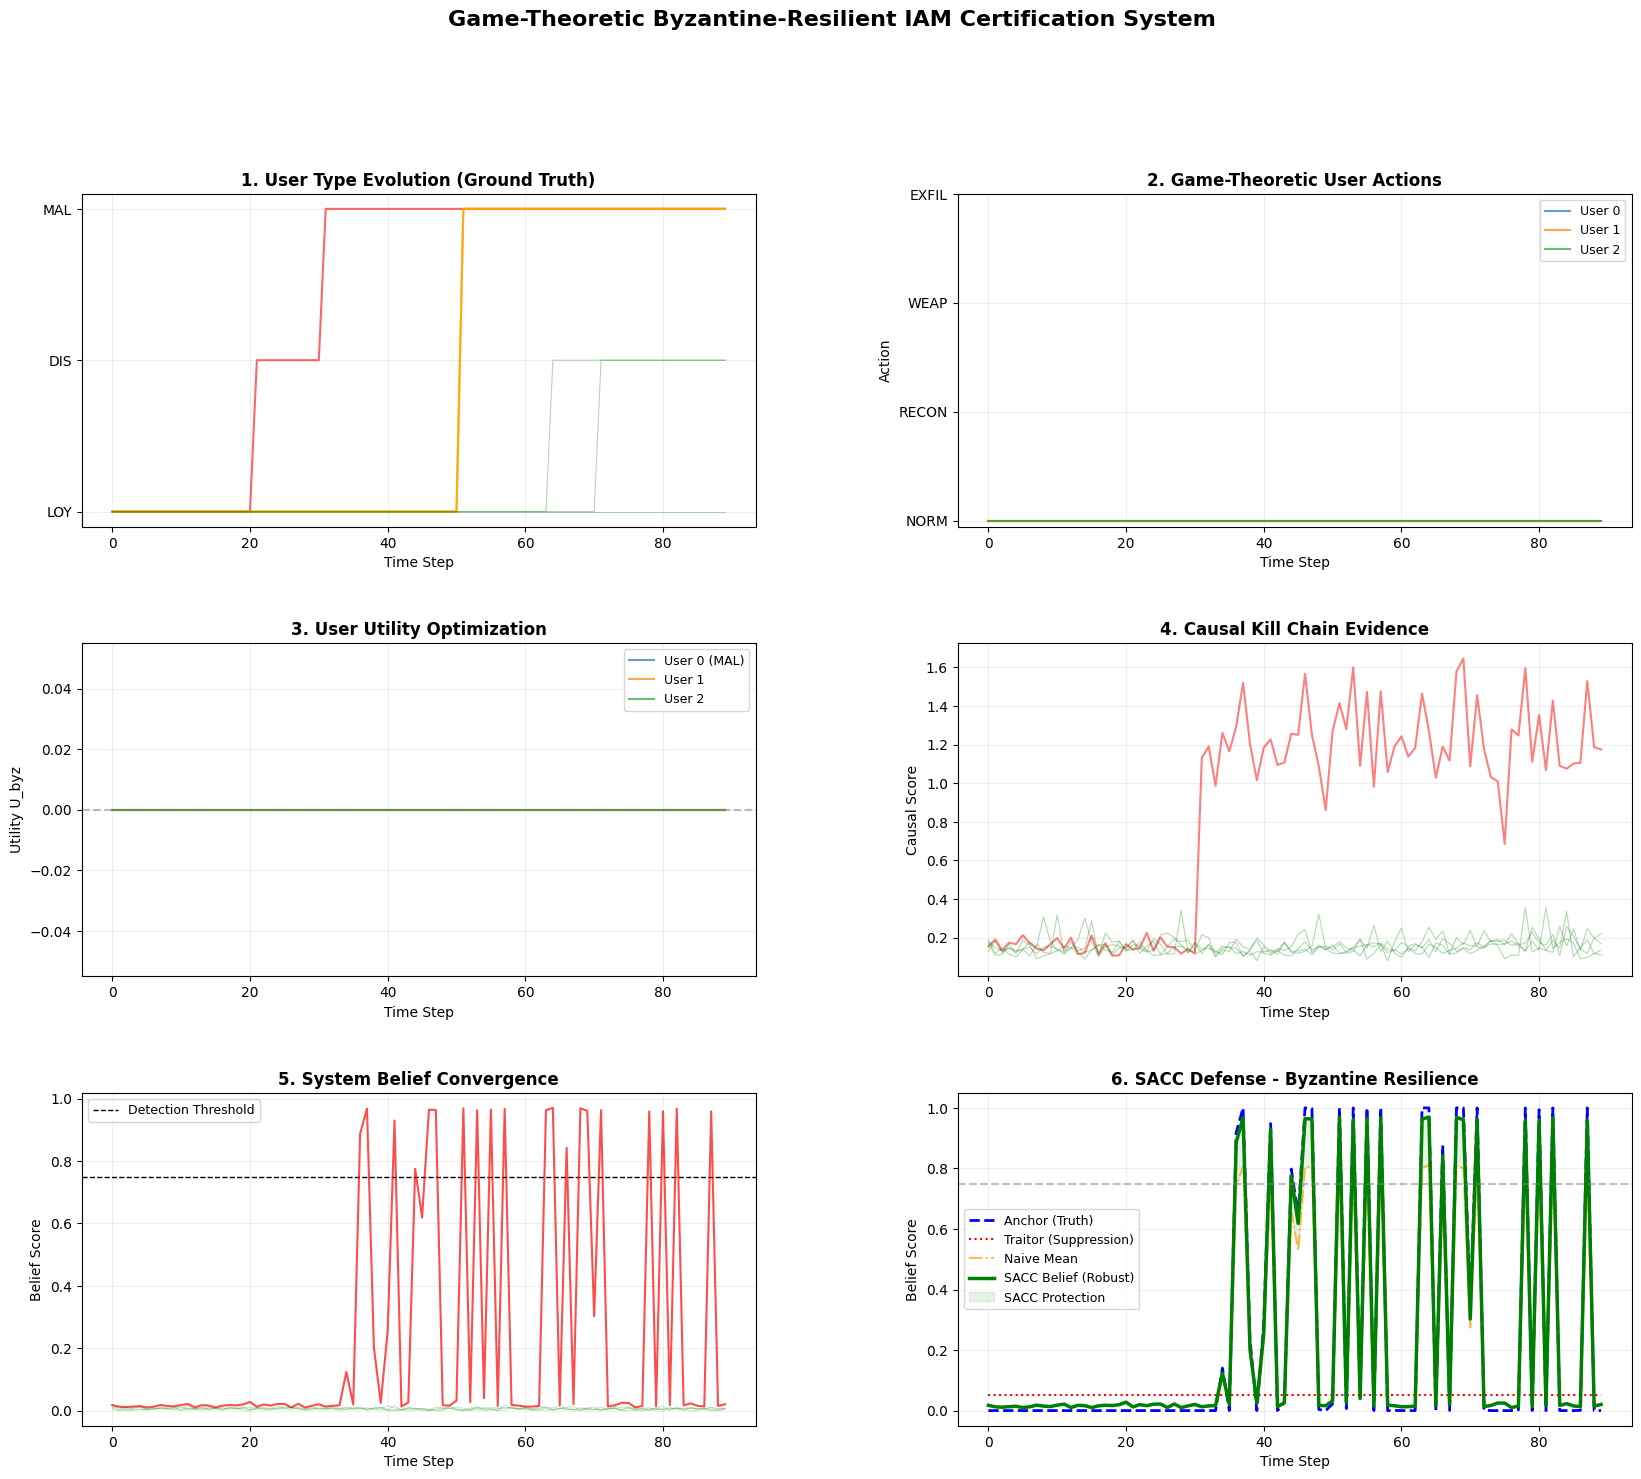


GAME-THEORETIC DETECTION METRICS
Total Users:          100
True Positives (TP):  1
False Positives (FP): 0
False Negatives (FN): 14

Precision:  1.0000
Recall:     0.0667
F1 Score:   0.1250

GAME THEORY ANALYSIS
Strategic Users: 100
Total Actions: 9000

Action Distribution:
  NORMAL: 9000 (100.0%)
  RECON: 0 (0.0%)
  WEAPONIZE: 0 (0.0%)
  EXFILTRATE: 0 (0.0%)


✓ Process Complete.


In [28]:

# ============================================================================
# MAIN
# ============================================================================
if __name__ == "__main__":
    if not os.path.exists("policies.json"):
        with open("policies.json", "w") as f:
            json.dump([
                {"signal_channel": "s_logon", "category": "Access", "severity": 0.6},
                {"signal_channel": "s_file", "category": "Reconnaissance", "severity": 0.7},
                {"signal_channel": "s_role", "category": "Privilege", "severity": 0.9},
                {"signal_channel": "s_exfil", "category": "Exfiltration", "severity": 0.8}
            ], f)

    print("="*60)
    print("RUNNING HYBRID SIMULATION")
    print("="*60)
    
    NUM_USERS = 100

    sim = ByzantineSimulation("policies.json")
    results = sim.run(n_users=NUM_USERS, pct_mal=0.15, horizon=90)
    
    FullVisualizer.plot_combined_dashboard(results, sim.committee, NUM_USERS)
    
    # Plot SACC Robustness for User 0 (Guaranteed Attacker)
    #FullVisualizer.plot_sacc_robustness(sim.committee, 0)
        
    print("\n✓ Process Complete.")